## One Hot Conditioning Of Noise

/home/anton/source/torch-env/lib/python3.12/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

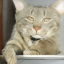

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from torchvision import transforms 

from diffusers import ConsistencyModelPipeline

device = "cuda"
model_id_or_path = "openai/diffusers-cd_imagenet64_l2"
pipe = ConsistencyModelPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
pipe.to(device)

CLASS = [281]

preprocess = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )

#pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)

# Multistep sampling
# Timesteps can be explicitly specified; the particular timesteps below are from the original GitHub repo:
# https://github.com/openai/consistency_models/blob/main/scripts/launch.sh#L83
image = pipe(num_inference_steps=40, class_labels=CLASS).images[0]
image

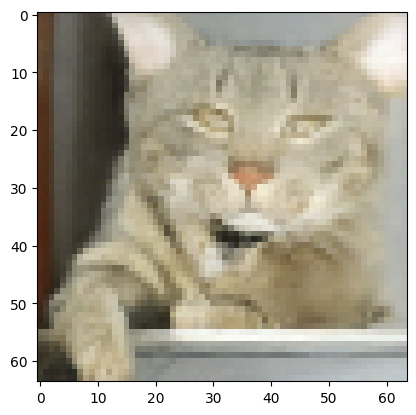

In [2]:
plt.imshow(
    np.moveaxis(np.array(transforms.ToTensor()(image)), 0, -1)
)

## Denoising function

In [79]:
def denoise(sample, sigma):
    
    t = pipe.scheduler.sigma_to_t(sigma)
    
    c_skip, c_out = pipe.scheduler.get_scalings_for_boundary_condition(sigma)
    
    scaled_sample = sample / ((sigma**2 + 1) ** 0.5)
    
    model_output = pipe.unet(
        scaled_sample, 
        t, 
        class_labels=torch.tensor(CLASS, device=device),
        return_dict=False
    )[0]

    
    return c_out * model_output + c_skip * sample

def model(sample, sigma):
    
    t = pipe.scheduler.sigma_to_t(sigma)
    
    c_skip, c_out = pipe.scheduler.get_scalings_for_boundary_condition(sigma)
    
    scaled_sample = sample / ((sigma**2 + 1) ** 0.5)
    
    model_output = pipe.unet(
        scaled_sample, 
        t, 
        class_labels=torch.tensor(CLASS, device=device),
        return_dict=False
    )[0]

    
    return model_output

## Denoise output

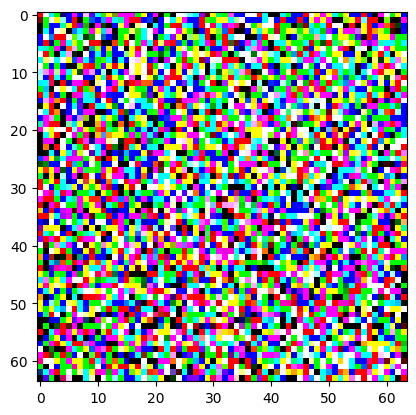

In [80]:
sigma = 7

img = preprocess(image)[None, :].to(device).type(torch.float16)

z = sigma * torch.randn(img.shape).to(device).type(torch.float16)

plt.imshow(
    pipe.postprocess_image((img + z).type(torch.float32), "np")[0]
)

/tmp/ipykernel_33914/3109570201.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_dn = torch.tensor(denoise(img + z, sigma).detach(), dtype=torch.float32)


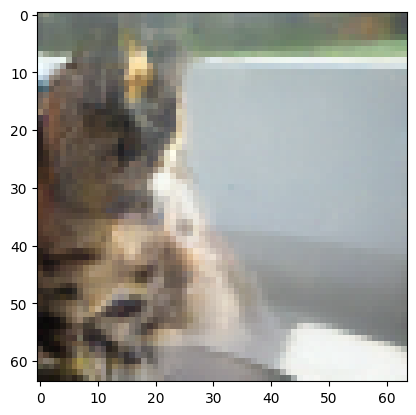

In [81]:
img_dn = torch.tensor(denoise(img + z, sigma).detach(), dtype=torch.float32)

plt.imshow(
    pipe.postprocess_image(img_dn.cpu(), "np")[0]
)

## One Hot Tests

In [215]:
def one_hot(i, dtype=torch.float16, num_classes=12288, reshape=True, device="cuda"):
    if isinstance(i, int):
        i = torch.tensor([i])

    oh = torch.nn.functional.one_hot(i, num_classes=num_classes).to(device).to(dtype)

    if reshape:
        oh = torch.reshape(oh[0], (1, 3, 64, 64))
        
    return oh

def denoise_and_plot(img, sigma):
    img_dn = denoise(img, sigma)
    img_dn = torch.tensor(img_dn.detach(), dtype=torch.float32)
    plt.imshow(
        pipe.postprocess_image(img_dn.cpu(), "np")[0]
    )

def model_and_plot(img, sigma):
    img_dn = model(img, sigma)
    img_dn = torch.tensor(img_dn.detach(), dtype=torch.float32)
    plt.imshow(
        pipe.postprocess_image(img_dn.cpu(), "np")[0]
    )

i = 2070 # + 2 * 64 * 64
sigma = 3

#img = one_hot(i) * torch.exp(torch.tensor([sigma], dtype=torch.float16)).to(device)

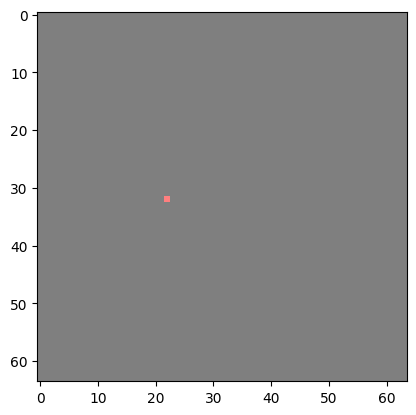

In [216]:
plt.imshow(
    pipe.postprocess_image(one_hot(i, dtype = torch.float32, device="cpu"), "np")[0]
)

/tmp/ipykernel_33914/3713245798.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_dn = torch.tensor(img_dn.detach(), dtype=torch.float32)


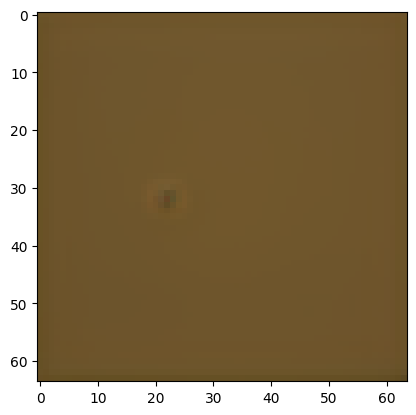

In [584]:
i = 2070 # + 2 * 64 * 64
sigma = 80
scale = 5

img = one_hot(i) * scale * sigma

z = sigma * torch.randn(img.shape).to(device).type(torch.float16)

img_n = img #+ z

model_and_plot(img_n, sigma=sigma)

## 2 basis vector combination

/tmp/ipykernel_33914/3713245798.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_dn = torch.tensor(img_dn.detach(), dtype=torch.float32)


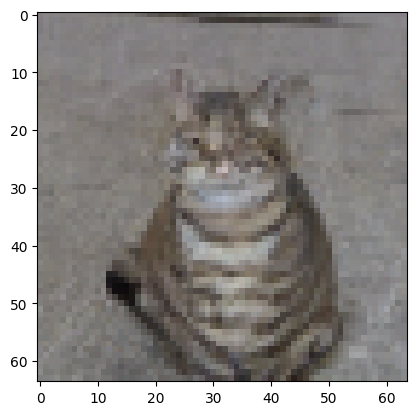

In [590]:
i = 2070 # + 2 * 64 * 64
j = 288

sigma = 5
scale = 1


e_i = one_hot(i)
e_j = one_hot(j)

img = (e_i + e_j) * 1 * sigma

z = sigma * torch.randn(img.shape).to(device).type(torch.float16)

img_n = img + z

denoise_and_plot(img_n, sigma=sigma)

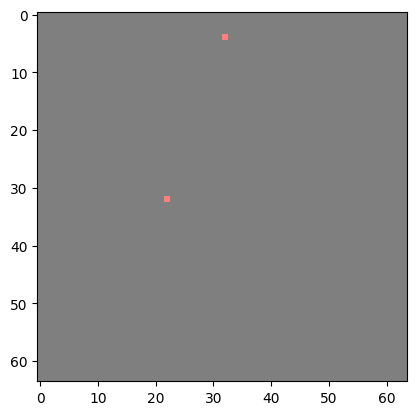

In [350]:
plt.imshow(
    pipe.postprocess_image(
        one_hot(i, dtype = torch.float32, device="cpu") + one_hot(j, dtype = torch.float32, device="cpu"), 
    "np")[0]
)